# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


In [2]:
warnings.filterwarnings("ignore")

# Configuration & Reproducibility

In [3]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"

IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 50

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Reshape Training Data

In [4]:
train_csv = pd.read_csv(f"{BASE_PATH}/train.csv")

train_df = train_csv.pivot_table(
    index="image_path",
    columns="target_name",
    values="target"
).reset_index()

train_df.fillna(0, inplace=True)


In [5]:
TARGET_COLUMNS = [
    'Dry_Green_g',
    'Dry_Dead_g',
    'Dry_Clover_g',
    'GDM_g',
    'Dry_Total_g'
]


# Train / Validation Split & Target Scaling

In [6]:
train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=SEED, shuffle=True
)


In [7]:
target_scaler = StandardScaler()
target_scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Definition

In [8]:
class BiomassDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform, scaler=None):
        self.df = dataframe.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]

        image = Image.open(
            os.path.join(self.image_dir, row.image_path)
        ).convert("RGB")
        image = self.transform(image)

        targets = np.array(
            [getattr(row, c) for c in TARGET_COLUMNS],
            dtype=np.float32
        )

        if self.scaler:
            targets = self.scaler.transform(targets.reshape(1, -1))[0]

        return image, torch.tensor(targets)


# Transforms & DataLoaders

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [10]:
train_loader = DataLoader(
    BiomassDataset(train_df, f"{BASE_PATH}/train", image_transforms, target_scaler),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    BiomassDataset(val_df, f"{BASE_PATH}/train", image_transforms, target_scaler),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)


# CNN Regression Model

In [11]:
class BiomassCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.regressor = nn.Linear(128, len(TARGET_COLUMNS))

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


In [12]:
model = BiomassCNN().to(DEVICE)


# Loss Function, Optimizer & Metric

In [13]:
TARGET_WEIGHTS = torch.tensor(
    [0.1, 0.1, 0.1, 0.2, 0.5],
    device=DEVICE
)


In [14]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)

    def forward(self, predictions, targets):
        return ((predictions - targets) ** 2 * self.weights).mean()


In [15]:
criterion = WeightedMSELoss(TARGET_WEIGHTS)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)


In [16]:
def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred) ** 2).sum(0)
    ss_tot = ((y_true - mean_y) ** 2).sum(0)
    r2 = 1 - (weights * ss_res).sum() / ((weights * ss_tot).sum() + 1e-8)
    return r2.item()


# Training / Validation Epoch Function

In [17]:
def run_epoch(model, dataloader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total_r2, count = 0.0, 0.0, 0

    with torch.set_grad_enabled(training):
        for images, targets in dataloader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            predictions = model(images)
            loss = criterion(predictions, targets)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_r2 += weighted_r2_score(targets, predictions, TARGET_WEIGHTS) * batch_size
            count += batch_size

    return total_loss / count, total_r2 / count


# Training Loop with History Tracking

In [18]:
train_losses, val_losses = [], []
train_r2s, val_r2s = [], []

best_val_r2 = -1e9

for epoch in range(NUM_EPOCHS):
    train_loss, train_r2 = run_epoch(model, train_loader, optimizer)
    val_loss, val_r2 = run_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), "best_model.pth")

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, R²: {train_r2:.4f} | "
        f"Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}"
    )


Epoch 1/50 | Train Loss: 0.2013, R²: -0.1382 | Val Loss: 0.1561, R²: -0.0901
Epoch 2/50 | Train Loss: 0.1956, R²: -0.0285 | Val Loss: 0.1466, R²: -0.0304
Epoch 3/50 | Train Loss: 0.1838, R²: 0.0347 | Val Loss: 0.1373, R²: 0.0016
Epoch 4/50 | Train Loss: 0.1781, R²: 0.0654 | Val Loss: 0.1318, R²: 0.0451
Epoch 5/50 | Train Loss: 0.1736, R²: 0.0968 | Val Loss: 0.1295, R²: 0.0782
Epoch 6/50 | Train Loss: 0.1712, R²: 0.0686 | Val Loss: 0.1311, R²: 0.0428
Epoch 7/50 | Train Loss: 0.1704, R²: 0.0118 | Val Loss: 0.1343, R²: -0.0096
Epoch 8/50 | Train Loss: 0.1630, R²: 0.0971 | Val Loss: 0.1242, R²: 0.1134
Epoch 9/50 | Train Loss: 0.1673, R²: 0.1071 | Val Loss: 0.1351, R²: -0.0118
Epoch 10/50 | Train Loss: 0.1645, R²: 0.0998 | Val Loss: 0.1211, R²: 0.1220
Epoch 11/50 | Train Loss: 0.1660, R²: 0.1156 | Val Loss: 0.1238, R²: 0.0847
Epoch 12/50 | Train Loss: 0.1615, R²: 0.1533 | Val Loss: 0.1319, R²: -0.0073
Epoch 13/50 | Train Loss: 0.1573, R²: 0.1415 | Val Loss: 0.1195, R²: 0.1043
Epoch 14/50 | 

# Training Curves (Loss & R²)

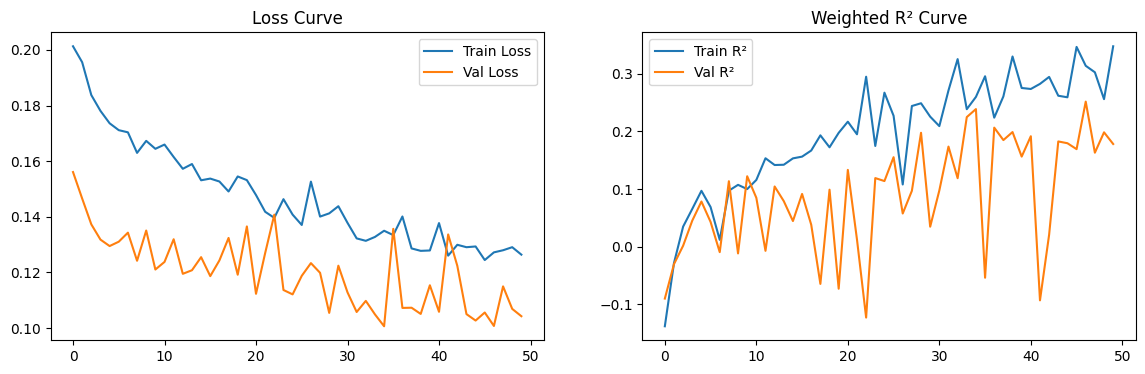

In [19]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_r2s, label="Train R²")
plt.plot(val_r2s, label="Val R²")
plt.legend()
plt.title("Weighted R² Curve")

plt.show()


# Load Best Model

In [20]:
best_model = BiomassCNN().to(DEVICE)
best_model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
best_model.eval()


BiomassCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=1)
  )
  (regressor): Linear(in_features=128, out_features=5, bias=True)
)

# Test Inference & Submission

In [21]:
test_dir = f"{BASE_PATH}/test"
submission_rows = []

with torch.no_grad():
    for file in tqdm(sorted(os.listdir(test_dir))):
        image = Image.open(os.path.join(test_dir, file)).convert("RGB")
        tensor = image_transforms(image).unsqueeze(0).to(DEVICE)

        preds_scaled = best_model(tensor).cpu().numpy()
        preds = target_scaler.inverse_transform(preds_scaled)[0]

        image_id = file.replace(".jpg", "")
        for name, value in zip(TARGET_COLUMNS, preds):
            submission_rows.append({
                "sample_id": f"{image_id}__{name}",
                "target": max(0, value)
            })


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


In [22]:
submission_df = pd.DataFrame(submission_rows)
submission_df.head()


,sample_id,target
0,ID1001187975__Dry_Green_g,17.660715
1,ID1001187975__Dry_Dead_g,18.764156
2,ID1001187975__Dry_Clover_g,2.354568
3,ID1001187975__GDM_g,20.842461
4,ID1001187975__Dry_Total_g,38.504654


In [23]:
submission_df.to_csv("submission.csv", index=False)